# Workshops Introduction:


Machine Learning:
 - Creating a Neural Network and using XGBoost (Dimitrii)

 - Implementing dynamic modelling (Dimitrii)
 
 - Hackathon (Zain)

Simulations:

 - Working with Monte Carlo

 - Species Population Simulation 

 - Hackathon (Zain)

Options:
 - Pricing Options

 - Creating Option Pricing Objects

 - Hackathon (Zain)

Alternative Data:
 - Downloading Alternative Data (computer vision on satellite imagery)

 - Twitter Trends (Web Scraping) analysis

 - Hackathon (Zain)

In [1]:
pip install yfinance

  Attempting uninstall: frozendict
    Found existing installation: frozendict 2.3.0
    Uninstalling frozendict-2.3.0:
      Successfully uninstalled frozendict-2.3.0
Note: you may need to restart the kernel to use updated packages.


Today we will teach you how to conduct price predictions with Neural Networks, and how to deal with noisy(spelling?) data and high speed calculations with XGBoost algorithms. 

# Data Production

In [2]:
import numpy as np
import sklearn as sk
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import tensorflow as tf
import matplotlib.pyplot as plt
import yfinance as yf
import datetime 
from datetime import timedelta

plt.rcParams["figure.figsize"] = (20,10)

In [3]:
today = datetime.datetime.now()
start_date = str((today- timedelta(days = 59)).strftime("%Y-%m-%d")) 
end_date = str(today.strftime("%Y-%m-%d"))
interval = "2m"

aapl_prices = yf.download('AAPL', start_date, end_date, interval=interval)[['Open', 'High', 'Low', 'Close']]

Target = aapl_prices['Close'].shift(-1) - aapl_prices['Open']

aapl_prices.head()

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close
Datetime,,,,
2022-12-07 09:30:00-05:00,142.190002,143.139999,142.130005,142.760101
2022-12-07 09:32:00-05:00,142.779999,143.089005,142.199997,143.054993
2022-12-07 09:34:00-05:00,143.059998,143.300003,142.919998,143.220001
2022-12-07 09:36:00-05:00,143.220001,143.369995,142.740005,142.750000
2022-12-07 09:38:00-05:00,142.732697,143.009995,142.270004,142.270004


In [4]:
scaled_aapl_prices = aapl_prices.pct_change()
scaled_aapl_prices['Target'] = Target
scaled_aapl_prices.describe()

,Open,High,Low,Close,Target
count,6.042000e+03,6042.000000,6.042000e+03,6.042000e+03,6042.000000
mean,-2.584967e-07,-0.000001,-3.713881e-07,-9.267604e-07,-0.001768
std,1.418374e-03,0.001318,1.282168e-03,1.413754e-03,0.254326
min,-1.503254e-02,-0.014211,-1.690651e-02,-1.686223e-02,-2.760010
25%,-6.326823e-04,-0.000515,-4.926004e-04,-6.406711e-04,-0.120010
50%,0.000000e+00,-0.000004,9.772766e-06,0.000000e+00,0.000000
75%,6.225797e-04,0.000496,5.066709e-04,6.190803e-04,0.119995
max,3.539027e-02,0.037232,3.339638e-02,3.297692e-02,4.869995


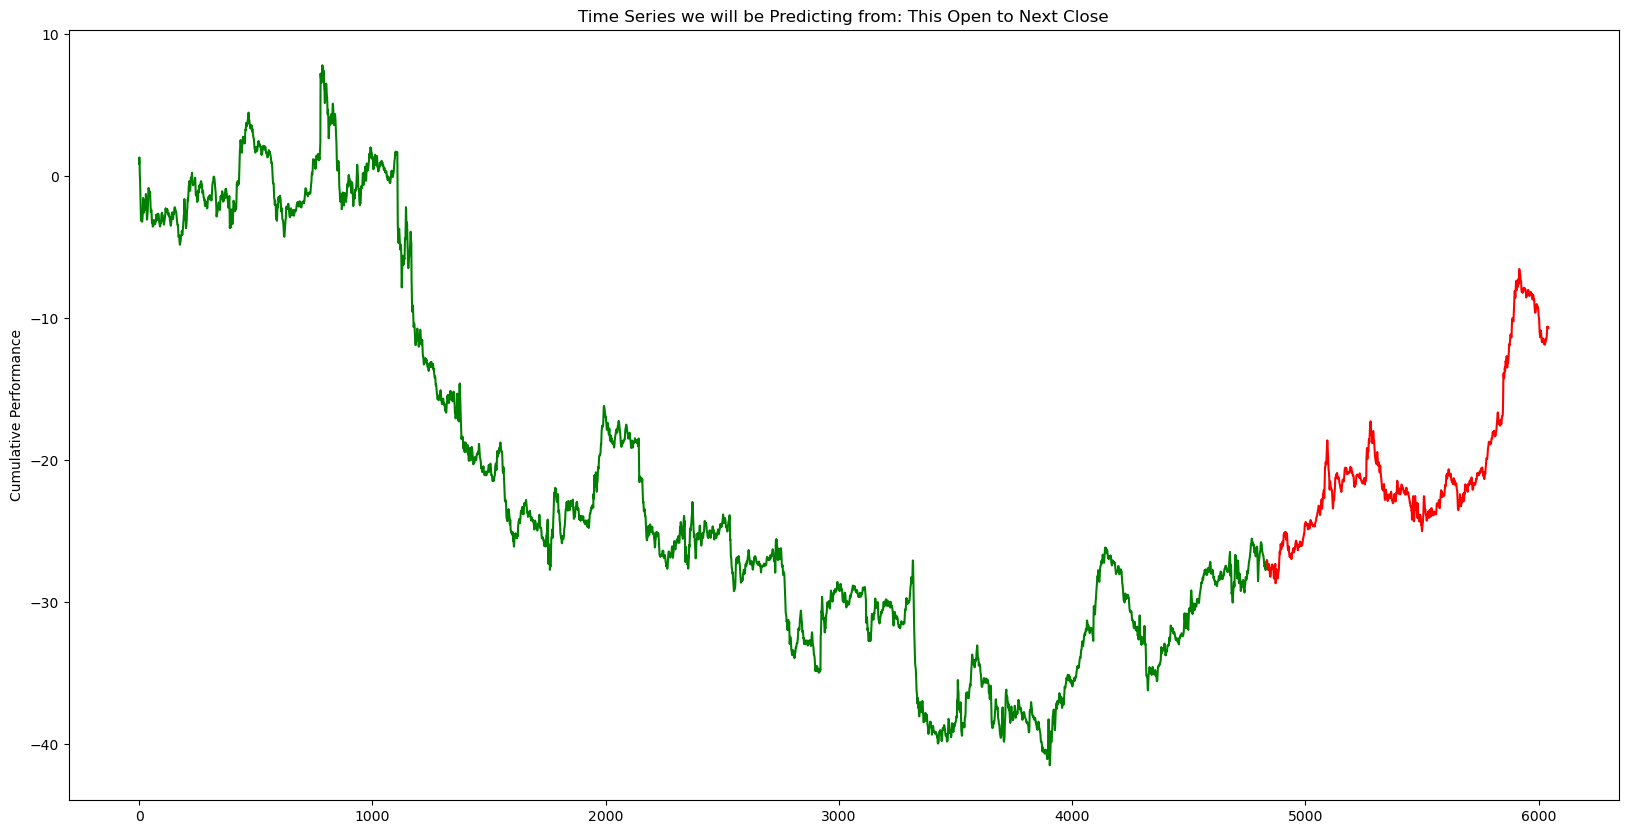

In [5]:
line_to_plot = Target.reset_index(drop=True)

ax = line_to_plot.cumsum()[:int(0.8*len(line_to_plot))].plot(color='g')
line_to_plot.cumsum()[int(0.8*len(line_to_plot)):].plot(color="r", ax=ax)

plt.title("Time Series we will be Predicting from: This Open to Next Close")
plt.ylabel("Cumulative Performance")
plt.show()

In [6]:
print("Index of NaN in Target: ", np.where(np.isnan(Target))[0], "\nIndex of NaN in AAPL_Prices: ", np.where(np.isnan(scaled_aapl_prices))[0])

Index of NaN in Target:  [6042] 
Index of NaN in AAPL_Prices:  [   0    0    0    0 6042]


In [7]:
print(scaled_aapl_prices.values[0], Target[0],"\n", scaled_aapl_prices.values[-1],  Target[-1])

[       nan        nan        nan        nan 0.86499023] 0.864990234375 
 [-0.000248   -0.00063737  0.00056727  0.                 nan] nan


In [8]:
def HowManyNaNs(X_train, X_test, y_train, y_test):
  print("X_train (size, Nans): ", X_train.shape, len(np.where(np.isnan(X_train))[0]))
  print("y_train (size, Nans): ", y_train.shape, len(np.where(np.isnan(y_train))[0]))
  print("X_test (size, Nans): ", X_test.shape, len(np.where(np.isnan(X_test))[0]))
  print("y_test (size, Nans): ", y_test.shape, len(np.where(np.isnan(y_test))[0]))

def PreprocessData(dataframe_of_data, train_split, random_state=0):
    #Ignore the NaN at the first datapoint
    X = dataframe_of_data.iloc[1:-1, :-1].values
    y = dataframe_of_data.iloc[1:-1, -1].values

    #do NOT se train_test_split function to split data into ratio for test and train
    #X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = train_split, random_state = random_state, shuffle=False)
    X_train = X[:int(0.8*len(X))]
    X_test = X[int(0.8*len(X)):]
    y_train = y[:int(0.8*len(X))]
    y_test = y[int(0.8*len(X)):]
  
    print("Number Of DataPoints in X: ",len(X), " and in y: ", len(y))
    print("Number of Test DataPoints: ", len(y_test))
    HowManyNaNs(X_train, X_test, y_train, y_test)
    return X_train, X_test, y_train, y_test

# Neural Networks

## Neural Network Theory

**Overview**


Deep neural network models were originally inspired by neurobiology. On a high level, a biological neuron receives multiple signals through the synapses contacting its dendrites and sends a single stream of action potentials out through axons. 
NN target brain-like functionality and  are based on a simple artificial neuron: a nonlinear function of a weighted sum of the inputs. During the inizialization of the neural network, the weights are placed randomly

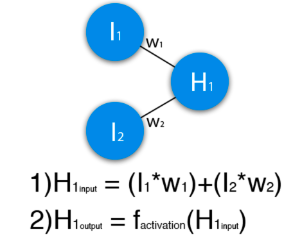

Activation function performs normalization, since the inputs of each neuron should be between 0 and 1 or -1 and 1

These pseudo neurons are collected into layers, and the inputs of one layer becoming the inputs of the next in the sequence.
3 main types of neurons: input(blue), hidden(red), output(green)

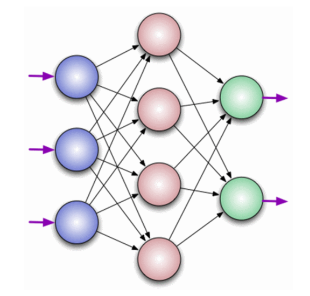

The term "deep" learning came from having many hidden layers, which are not visible.

Training a neural network basically means calibrating all the "weights" by repeating two steps: forward propagation and backward propagation.
In forward propagation we apply a set of weights to the input data and calculate an output.
In backward propagation we measure the margin of error of the output and adjust weights to decrease the error

**Types**

1) **Multi-Layer Perceptrons(MLP)**
is the most basic NN, which is composed of a series of fully connected layers. Each new layer is a set of simple artificial neurons.

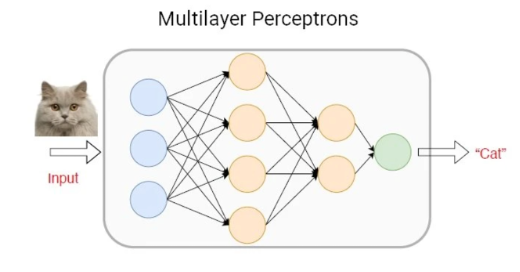

2) **Convolutional Neural Network(CNN)**. Here one or mulitple convolutional layers extract the simple features from input by executing convolutional operations. Each layer is a set of nonlinear functions of weighted sums at different coordinates of spatially nearby subsets of outputs from the prior layer, which allows the weights to be reused.

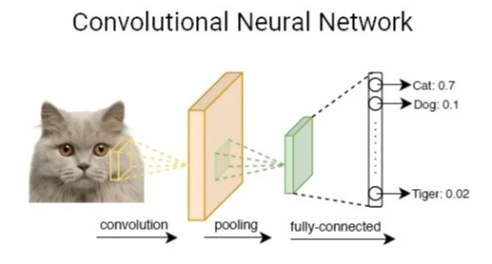

 They are widely used in Computer Vision

3) **Recurrent Neural Network(RNN)** have been developed to address the time-series problem of sequential input data. The input of RNN consists of current input and the previous samples. Furthermore, each neuron owns an internal memory that keeps the information of the computation from the previous samples.

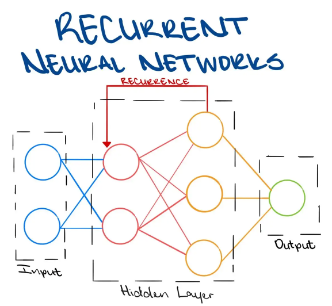

Widely used in Natural Language Processing(NLP)

**Summary**



**Pros:**

*   Once trained, the predictions are fast
*   Good for nonlinear data with large number of inputs; for example, images
* Usually performs better than classic ML algorithms with sufficient amount of data
* Can be used for both - regression and classification

**Cons**
* Hard to explain and Interpret 
* Computationally expensive and time consuming
* Requires a lot of training data



**References**

1) How to build a neural network:
http://stevenmiller888.github.io/mind-how-to-build-a-neural-network/

2) 3 popular types:
https://viso.ai/deep-learning/deep-neural-network-three-popular-types/

## Neural Network Code

In [9]:
X_train, X_test, y_train, y_test = PreprocessData(scaled_aapl_prices, 0.8)

sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

def CreateModel(units_1, units_2):
    #Define our basic neural networn (nn) object
    nn = tf.keras.models.Sequential()
    #Add layers of perceptrons. These could be Dense as below, or Concolutions or LSTMs 
    nn.add(tf.keras.layers.Dense(units=units_1, activation='sigmoid'))
    nn.add(tf.keras.layers.Dense(units=units_2, activation='sigmoid'))
    #Ensure there is 1 output, as there is a 1-to-1 mapping between row and prediction size
    nn.add(tf.keras.layers.Dense(units=1))#, activation='sigmoid')) 
    return nn

Number Of DataPoints in X:  6041  and in y:  6041
Number of Test DataPoints:  1209
X_train (size, Nans):  (4832, 4) 0
y_train (size, Nans):  (4832,) 0
X_test (size, Nans):  (1209, 4) 0
y_test (size, Nans):  (1209,) 0


In [10]:
batch_size = 100
epochs = 1000

early_stop = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)

nn = CreateModel(16, 16)
nn.compile(optimizer = 'adam', loss = 'huber_loss')
nn.fit(X_train, y_train, batch_size = batch_size, epochs = epochs,callbacks=[early_stop], verbose = 0)

2023-01-24 01:29:52.838160: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


### Evaluation

38/38 [==============================] - 0s 343us/step


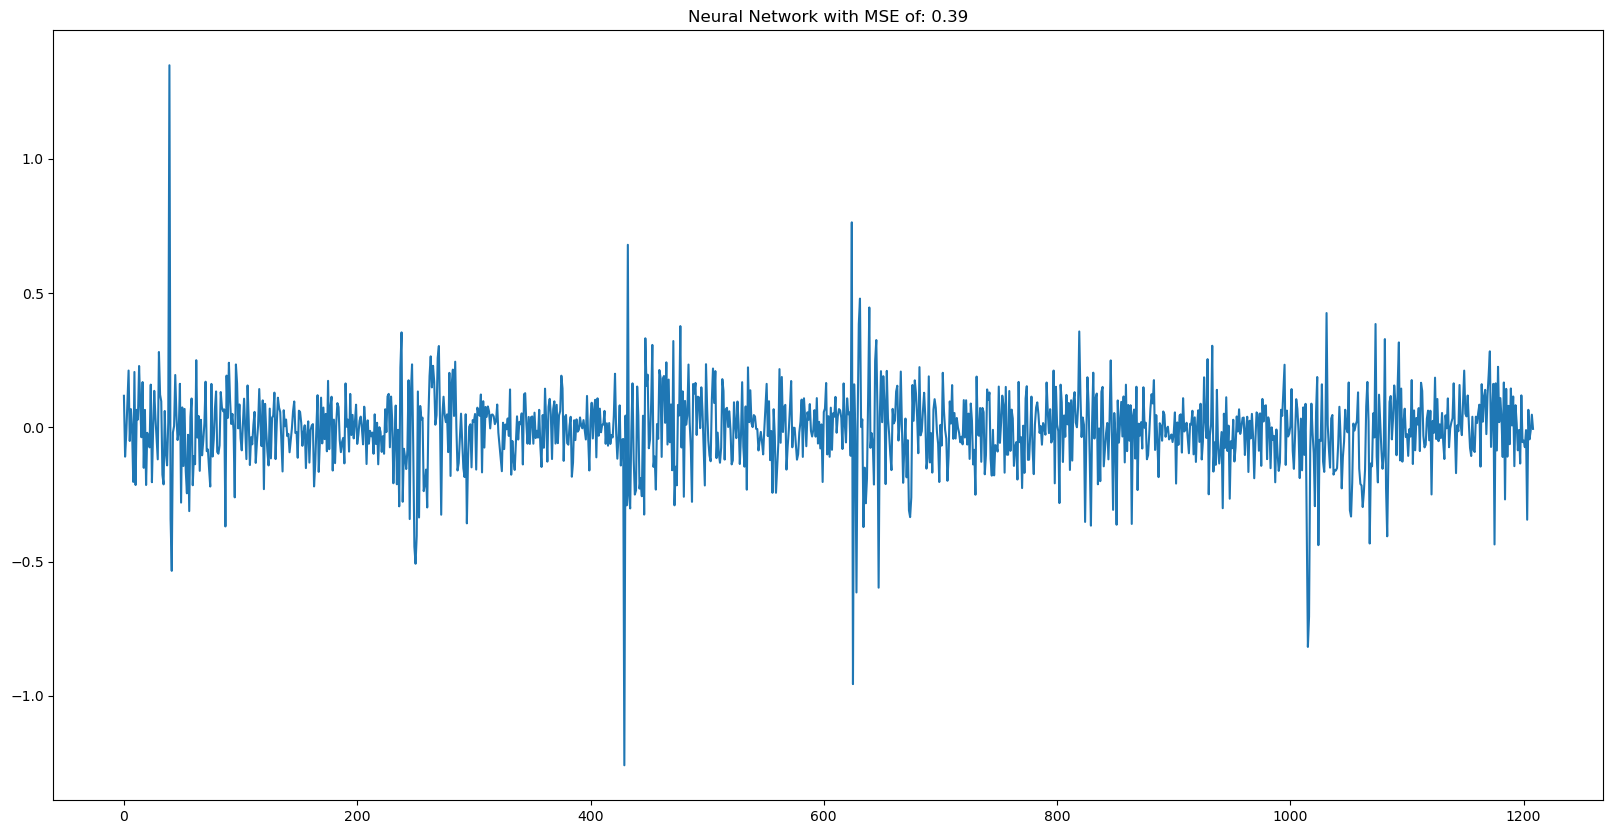

In [11]:
nn_pred = nn.predict(X_test)
nn_error = (np.ravel(nn_pred) - y_test)
plt.plot(nn_error)
plt.title("Neural Network with MSE of: "+str(round(np.sqrt(sk.metrics.mean_squared_error(y_test, nn_pred, squared=False)), 3)))
plt.show()

But its slow...how slow?

In [12]:
import time

def TimeFunctionCall(function_call, repeats=1):
    total = 0
    for i in range(repeats):
        start= time.perf_counter()
        function_call
        end= time.perf_counter()
        total += end-start
    return total/repeats

random_array = np.random.rand(1,4)
TimeFunctionCall(nn.predict(random_array), 2000000)

1/1 [==============================] - 0s 9ms/step


5.196936463471502e-08

Lets run a faster algorithm, XGBoost:

# XGBoost

## XGBoost Theory

**Overview**

XGBoost is a popular and efficient open-source implementation of the gradient boosted trees algorithm. What makes XGBoost better?
- advanced regularization, which improves model generalization capabilities.
- Its training is very fast and can be parallelized across clusters

But what is Gradient Boosting?

It all started with the question of whether it is possible to get one strong model from a large number of relatively weak and simple models. This approach is now called *Bagging*. Random forest is a famous bagging model which uses variations of multiple trees. The trees are built to be independent or at least less correlated. This helps to decrease variance and prevent overfitting.

Why does this work?

Let $Var(M_i) = σ$ and our resulting prediction is an average of all weak learners, then resulting variance is:

$$
Var(\frac{(M_1+...+M_n)}{n}) = \frac{1}{n^2} * n * σ = \frac{σ}{n}
$$

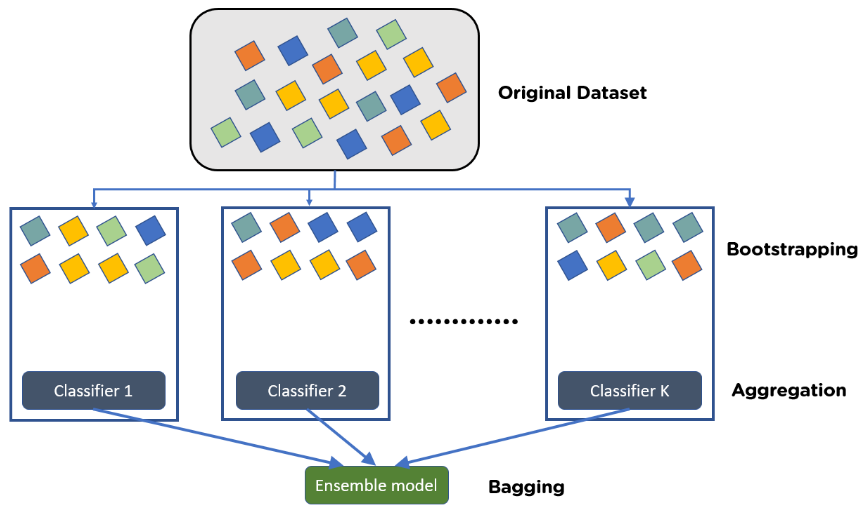

In Bagging we created independent trees and calculated their average or weighted average. *Boosting* for each new learner uses previous predictions and new learners are added sequantially 

The first realization of boosting that saw great success in application was Adaptive Boosting or AdaBoost for short. The weak learners in AdaBoost are decision trees with a single split, called decision stumps for their shortness. Predictions are made by majority vote of the weak learners’ predictions, weighted by their individual accuracy.

Gradient boosting was further developed by Friedman. The objective is to minimize the loss of the model by adding weak learners using a gradient descent like procedure. 

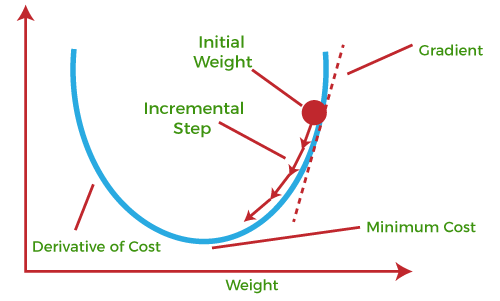

Decision trees are used as the weak learner in gradient boosting.
Trees are added one at a time, and existing trees in the model are not changed.

After calculating the loss on a new tree, to perform the gradient descent procedure, we must add a tree to the model that reduces the loss (i.e. follow the gradient). We do this by parameterizing the tree, then modify the parameters of the tree and move in the right direction (reducing the residual loss)

The output for the new tree is then added to the output of the existing sequence of trees to correct or improve the final output of the model.



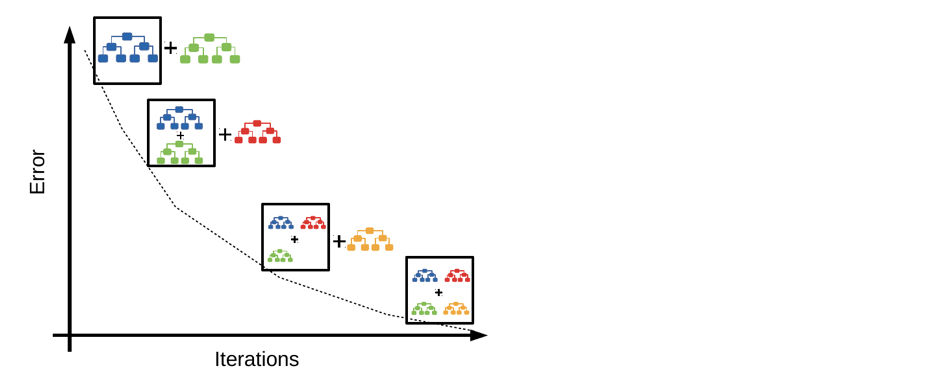

Training stops once loss reaches an acceptable level or no longer improves on an external validation dataset.

Overall view of the algorithm


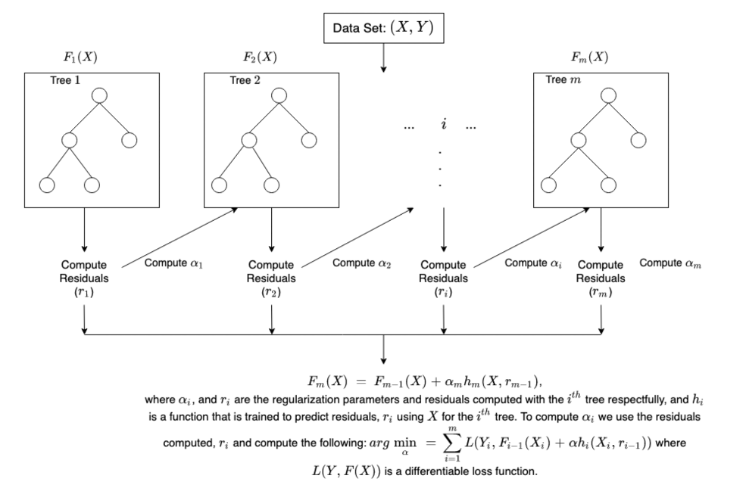

**When not to use XGBoost?**


*   number of observations in training data is significantly small
*   image recognition
*   computer vision
*   NLP



**References**

1) https://machinelearningmastery.com/gentle-introduction-gradient-boosting-algorithm-machine-learning/

2) https://towardsdatascience.com/all-you-need-to-know-about-gradient-boosting-algorithm-part-1-regression-2520a34a502

3) https://www.geeksforgeeks.org/xgboost/

## XGBoost Code

In [13]:
pip install xgboost

Note: you may need to restart the kernel to use updated packages.


In [14]:
from xgboost import XGBRegressor

/Users/savindmitriy/miniforge3/lib/python3.10/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [15]:
X_train, X_test, y_train, y_test = PreprocessData(scaled_aapl_prices, 0.8)

Number Of DataPoints in X:  6041  and in y:  6041
Number of Test DataPoints:  1209
X_train (size, Nans):  (4832, 4) 0
y_train (size, Nans):  (4832,) 0
X_test (size, Nans):  (1209, 4) 0
y_test (size, Nans):  (1209,) 0


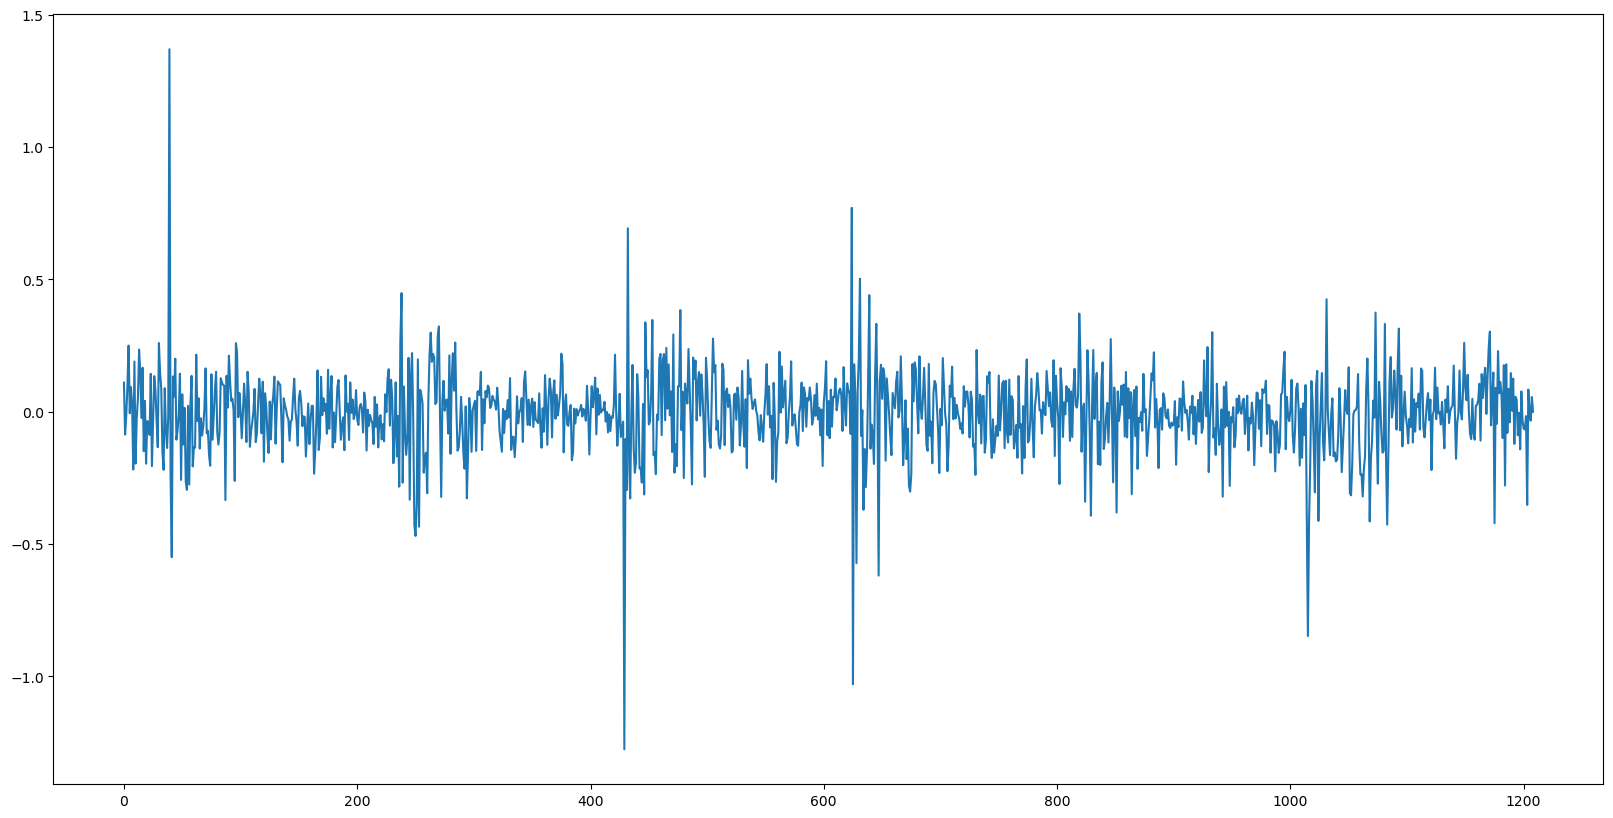

In [16]:
# URL: https://xgboost.readthedocs.io/en/latest/python/python_api.html#:~:text=interface%20for%20XGBoost.-,class,xgboost.XGBRegressor,-(*%2C
xgbr = XGBRegressor(random_state = 0, 
                    objective ='reg:squarederror',
                    learning_rate = 0.05, 
                    n_estimators=100,
                    max_depth=4)

xgbr.fit(X_train, y_train)

xgb_pred = xgbr.predict(X_test)
xgb_error = xgb_pred - y_test

plt.plot(xgb_error, label = 'XGB')

In [17]:
import pandas as pd
pd.DataFrame(100*xgbr.feature_importances_.reshape(1, -1), columns=scaled_aapl_prices.columns[:-1])

,Open,High,Low,Close
0,8.224271,7.796801,8.315122,75.663803


How much faster is it than the NN?

In [18]:
random_array = np.random.rand(1,4)
TimeFunctionCall(xgbr.predict(random_array), 200000000) / TimeFunctionCall(nn.predict(random_array), 200000000)

1/1 [==============================] - 0s 7ms/step


1.00541136753951

# Evaluations

## Error Comparisons

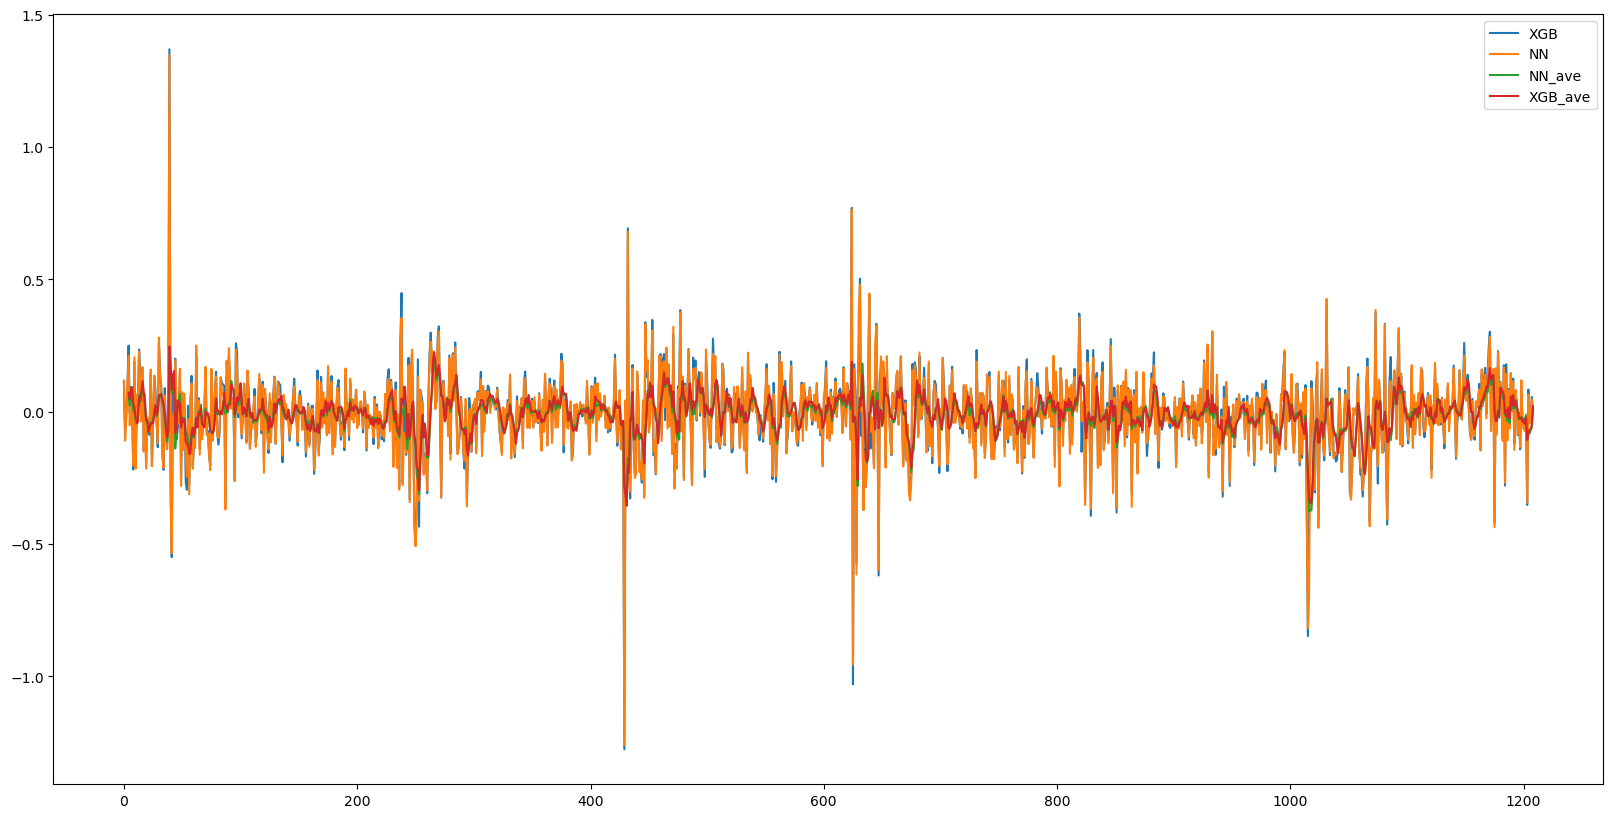

In [19]:
plt.plot(xgb_error, label = 'XGB')
plt.plot(nn_error, label='NN')
plt.plot(pd.Series(nn_error).rolling(5).mean(), label='NN_ave')
plt.plot(pd.Series(xgb_error).rolling(5).mean(), label='XGB_ave')

plt.legend()

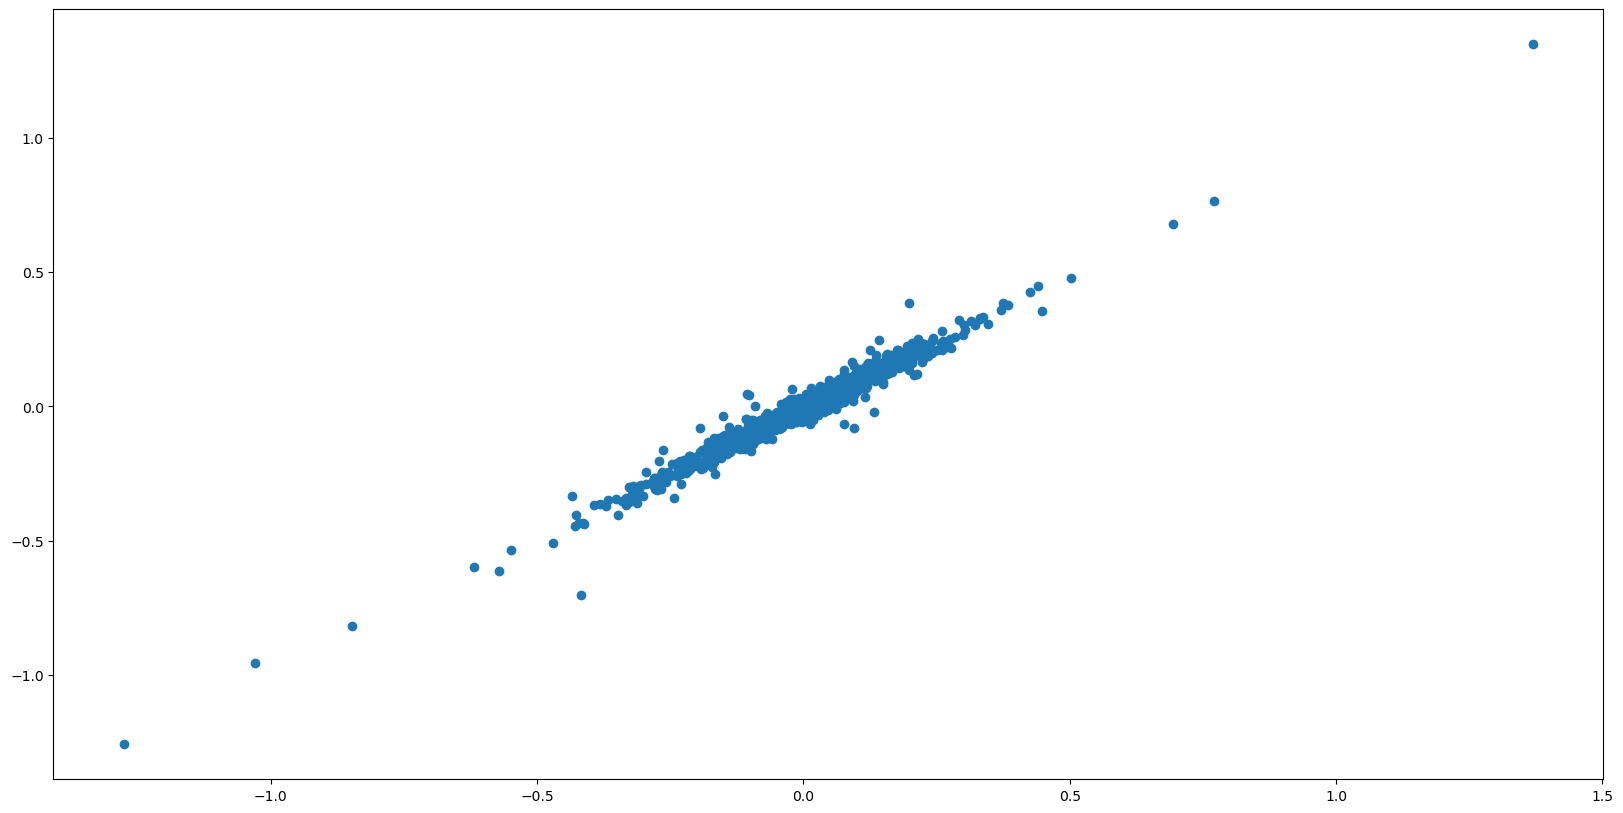

In [20]:
plt.scatter(xgb_error, nn_error, label = 'XGB')

## Time Series Comparisons

Text(0.5, 1.0, 'Time Series of Predictions from Test Data')

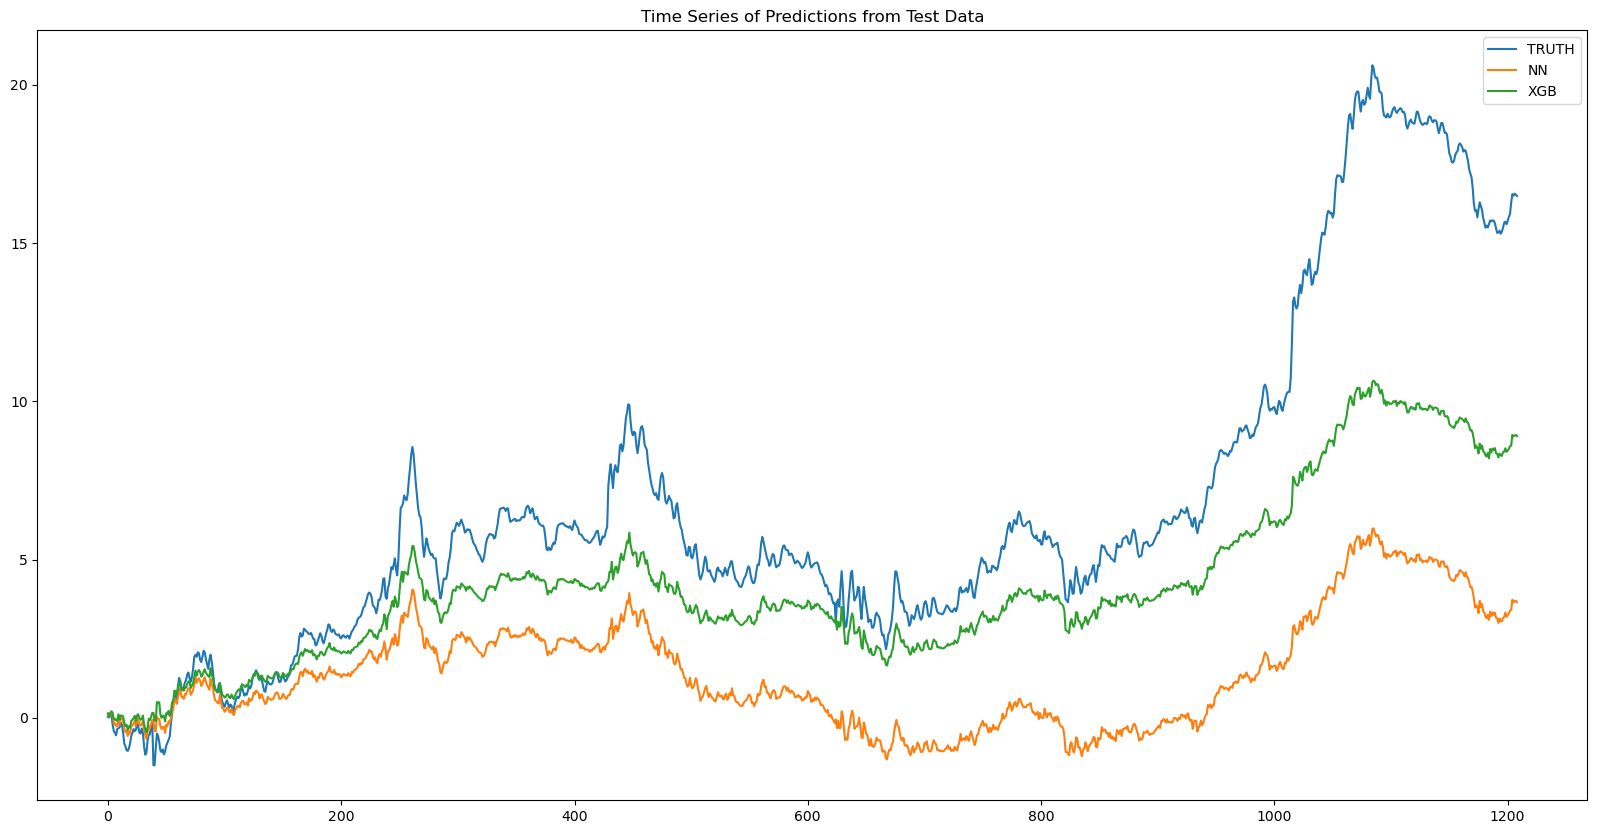

In [21]:
plt.plot(y_test.cumsum(), label = 'TRUTH')
plt.plot(nn_pred.cumsum(), label = 'NN')
plt.plot(xgb_pred.cumsum(), label = 'XGB')
plt.legend()
plt.title("Time Series of Predictions from Test Data")

Text(0.5, 1.0, 'Time Series of Predictions from Test Data')

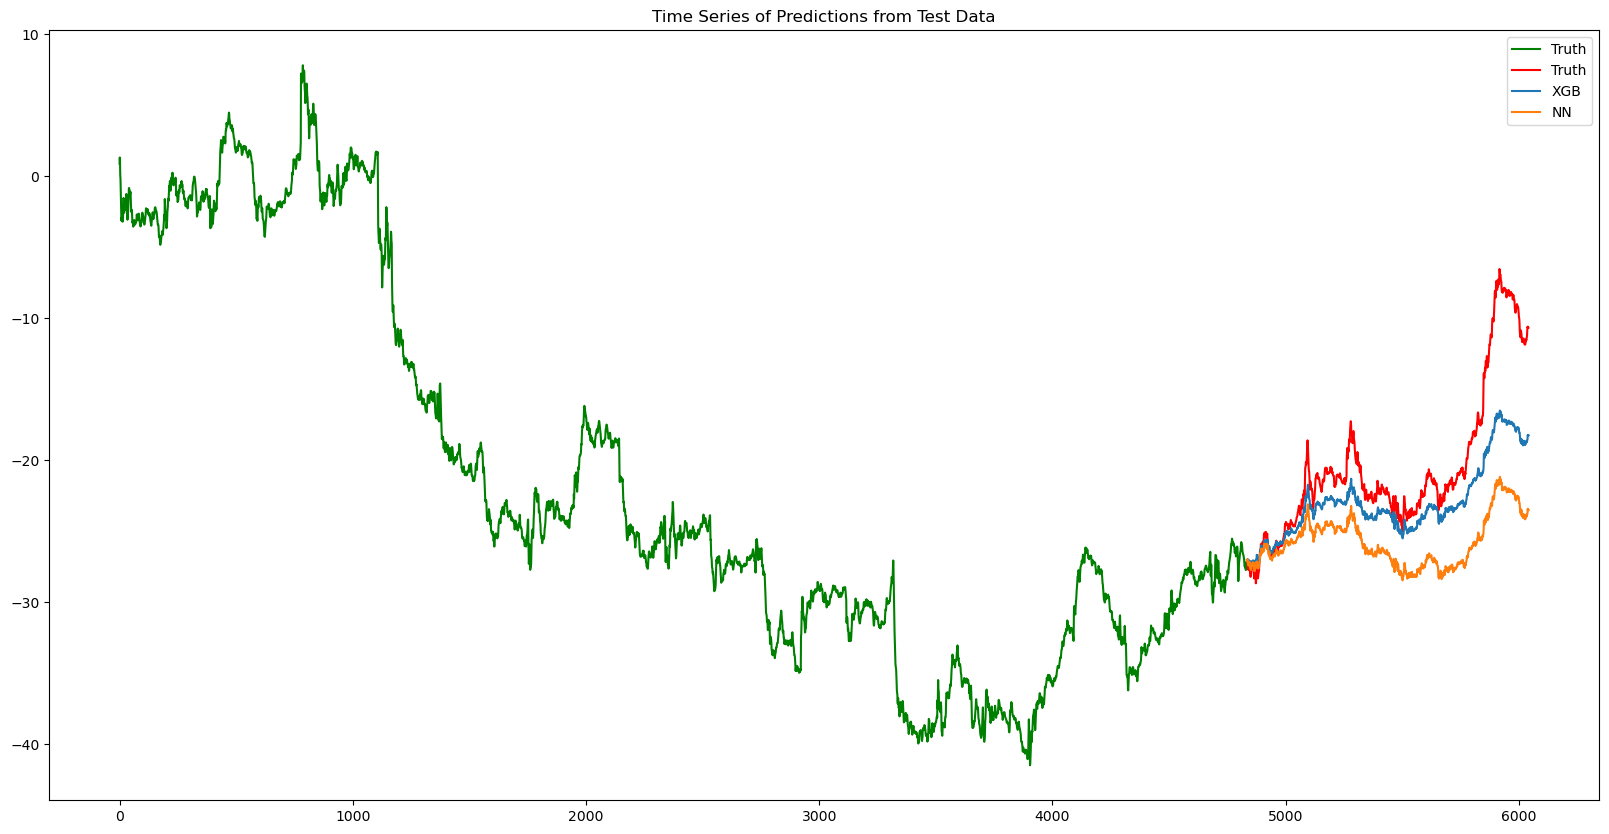

In [22]:
line_to_plot = Target.reset_index(drop=True)

ax = line_to_plot.cumsum()[:int(0.8*len(line_to_plot))].plot(color='g', label = 'Truth')
line_to_plot.cumsum()[int(0.8*len(line_to_plot)):].plot(color="r", ax=ax, label = 'Truth')

final_training_point = line_to_plot.cumsum()[int(0.8*len(line_to_plot))]

ax.plot(np.arange(int(0.8*len(line_to_plot)),len(line_to_plot)), (xgb_pred.cumsum())+final_training_point, label = 'XGB')
ax.plot(np.arange(int(0.8*len(line_to_plot)),len(line_to_plot)), (nn_pred.cumsum())+final_training_point, label = 'NN')
plt.legend()
plt.title("Time Series of Predictions from Test Data")